In [ ]:
# For streaming
import sys
version = sys.version_info
if version.major < 3 or (version.major == 3 and version.minor < 10):
    raise RuntimeError("This script requires Python 3.10 or higher")
import os
from typing import Iterable

# Add scripts directory to Python path
scripts_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..", "..", "scripts"))
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

from file_streams import getFileJsonStream
from utils import FileProgressLog

# For processing
import gensim
from gensim.models import Word2Vec
import re
import logging
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
    
import datetime
import random
import numpy as np
import html
import unicodedata

# # Download necessary NLTK resources
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt', quiet=True)
# nltk.download('averaged_perceptron_tagger', quiet=True)  # For POS tagging

recursive = False


def processFile(path, party, output_dir, without_stopwords=True):
    print(f"Processing file {path}")
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Create empty lists for each time period
    chunks = {
        "before_2016": [],
        "2017_2020": [],
        "2021_2024": [],
    }
    
    # Track counts
    counts = {period: 0 for period in chunks.keys()}
    
    POS_CACHE = {}
    LEMMA_CACHE = {}
    
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Skipping unknown file {path}")
            return
        for row in tqdm(jsonStream, desc="Processing comments"):
            if "body" not in row or "created_utc" not in row:
                continue
            
            # Get the comment text and timestamp
            text = row["body"]
            created_timestamp = row["created_utc"]
            author = row["author"]
            if author in {"AutoModerator", "election_info_bot"}:
                continue
            
            # Convert timestamp to year
            year = datetime.datetime.fromtimestamp(int(created_timestamp)).year
            
            # Determine which chunk this comment belongs to
            chunk_key = None
            if year <= 2016:
                chunk_key = "before_2016"
            elif 2017 <= year <= 2020:
                chunk_key = "2017_2020"
            elif 2021 <= year <= 2024:
                chunk_key = "2021_2024"
            
            # Process text
            # Handle HTML entities
            text = html.unescape(text)
            
            # Unicode normalization
            text = unicodedata.normalize('NFKD', text)
            
            # Remove URLs and Markdown formatting
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
            text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
            text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
            text = re.sub(r'\*(.*?)\*', r'\1', text)
            
            # Remove subreddit and user references
            text = re.sub(r'/r/\w+', '', text)
            text = re.sub(r'r/\w+', '', text)
            text = re.sub(r'/u/\w+', '', text)
            text = re.sub(r'u/\w+', '', text)
            
            # Basic text cleaning
            text = re.sub("[^A-Za-z]+", ' ', text).lower()
            
            # Remove single letters (except 'i')
            text = re.sub(r'\b([a-hj-z])\b', '', text)
            
            # Tokenize
            words = text.split()
            
            # Skip empty comments
            if not words:
                continue
            
            # Filter stop words
            if without_stopwords:
                words_to_tag = []
                for word in words:
                    if word not in stop_words:
                        words_to_tag.append(word)
            else:
                words_to_tag = words[:]
                
            if not words_to_tag:
                continue
            
            # POS Cache
            uncached_words = []
            for word in words_to_tag:
                if word not in POS_CACHE:
                    uncached_words.append(word)

            if uncached_words:
                tagged_uncached = nltk.pos_tag(uncached_words)
                for word, tag in tagged_uncached:
                    POS_CACHE[word] = tag

            processed_words = []
            for word in words_to_tag:
                tag = POS_CACHE[word]
                # Convert to wordnet_pos
                if tag.startswith('J'):
                    wordnet_pos = 'a'
                elif tag.startswith('V'):
                    wordnet_pos = 'v'
                elif tag.startswith('N'):
                    wordnet_pos = 'n'
                elif tag.startswith('R'):
                    wordnet_pos = 'r'
                else:
                    wordnet_pos = 'n'

                lemma_key = (word, wordnet_pos)
                if lemma_key in LEMMA_CACHE:
                    lemma = LEMMA_CACHE[lemma_key]
                else:
                    lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
                    LEMMA_CACHE[lemma_key] = lemma

                processed_words.append(lemma)

            if processed_words:
                chunks[chunk_key].append(processed_words)
                counts[chunk_key] += 1
                
    # Print statistics
    print("\n=== Comment Counts by Period ===")
    for period, count in counts.items():
        print(f"{period}: {count} comments")
        
    # Extract bigrams from each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            # Build bigram model
            phrases = Phrases(comments, min_count=5, threshold=10)
            bigram_model = Phraser(phrases)
            
            # Apply bigram model to create comments with bigrams
            bigrammed_comments = [bigram_model[comment] for comment in comments]
            chunks[period] = bigrammed_comments
        
    # Train a Word2Vec model for each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            # Initialize and train model
            model = Word2Vec(
                vector_size=300,
                window=5,
                min_count=5,
                workers=16,
                seed=23
            )
            
            # Build vocabulary
            model.build_vocab(comments)
            print(f"{period} vocabulary size: {len(model.wv.index_to_key)}")
            
            # Train the model
            model.train(
                comments, 
                total_examples=len(comments), 
                epochs=5
            )
            
            # Save the model
            model_path = f"{output_dir}/{party}_{period}.model"
            model.save(model_path)
            print(f"Model saved to {model_path}")
            
        
def main():
    filePathforDemocrats = r"datasets/democrats_comments.zst"
    filePathforRepublican = r"datasets/Republican_comments.zst"
    filePathforConservative = r"datasets/Conservative_comments.zst"
    filePathforLiberal = r"datasets/Liberal_comments.zst"
    filePathforVagabond = r"datasets/vagabond_comments.zst"
    filePathforbackpacking = r"datasets/backpacking_comments.zst"


    random.seed(23)
    np.random.seed(23)
    output_dir = "models/final_full"
    os.makedirs(output_dir, exist_ok=True)
    # processFile(filePathforDemocrats, "democrats", output_dir)
    # processFile(filePathforRepublican, "republican", output_dir)
    processFile(filePathforConservative, "conservative", output_dir)
    processFile(filePathforLiberal, "liberal", output_dir)
    processFile(filePathforVagabond, "vagabond", output_dir)
    processFile(filePathforbackpacking, "backpacking", output_dir)
    print("Done :>")

if __name__ == "__main__":
    main()


Processing file datasets/Conservative_comments.zst


Processing comments: 18984143it [08:25, 37575.38it/s]



=== Comment Counts by Period ===
before_2016: 1478038 comments
2017_2020: 6675232 comments
2021_2024: 10634806 comments
before_2016 vocabulary size: 77439
Model saved to models/final_full/conservative_before_2016.model
2017_2020 vocabulary size: 136822
Model saved to models/final_full/conservative_2017_2020.model
2021_2024 vocabulary size: 146174
Model saved to models/final_full/conservative_2021_2024.model
Processing file datasets/Liberal_comments.zst


Processing comments: 497079it [00:17, 27952.05it/s]



=== Comment Counts by Period ===
before_2016: 131498 comments
2017_2020: 145815 comments
2021_2024: 213348 comments
before_2016 vocabulary size: 25727
Model saved to models/final_full/liberal_before_2016.model
2017_2020 vocabulary size: 21412
Model saved to models/final_full/liberal_2017_2020.model
2021_2024 vocabulary size: 24120
Model saved to models/final_full/liberal_2021_2024.model
Processing file datasets/vagabond_comments.zst


Processing comments: 513168it [00:18, 27724.83it/s]



=== Comment Counts by Period ===
before_2016: 39323 comments
2017_2020: 156983 comments
2021_2024: 292174 comments
before_2016 vocabulary size: 12108
Model saved to models/final_full/vagabond_before_2016.model
2017_2020 vocabulary size: 24860
Model saved to models/final_full/vagabond_2017_2020.model
2021_2024 vocabulary size: 30659
Model saved to models/final_full/vagabond_2021_2024.model
Processing file datasets/backpacking_comments.zst


Processing comments: 866545it [00:31, 27240.85it/s]



=== Comment Counts by Period ===
before_2016: 160438 comments
2017_2020: 225801 comments
2021_2024: 428565 comments
before_2016 vocabulary size: 26261
Model saved to models/final_full/backpacking_before_2016.model
2017_2020 vocabulary size: 26477
Model saved to models/final_full/backpacking_2017_2020.model
2021_2024 vocabulary size: 41062
Model saved to models/final_full/backpacking_2021_2024.model
Done :>



Comparing models:
before_2016: Common vocabulary between democrats and conservative: 18871 words
Results saved to output/final_full/democrats_conservative_before_2016.csv
2017_2020: Common vocabulary between democrats and conservative: 29505 words
Results saved to output/final_full/democrats_conservative_2017_2020.csv
2021_2024: Common vocabulary between democrats and conservative: 45135 words
Results saved to output/final_full/democrats_conservative_2021_2024.csv

Analysis complete. Generated 6 comparison files.


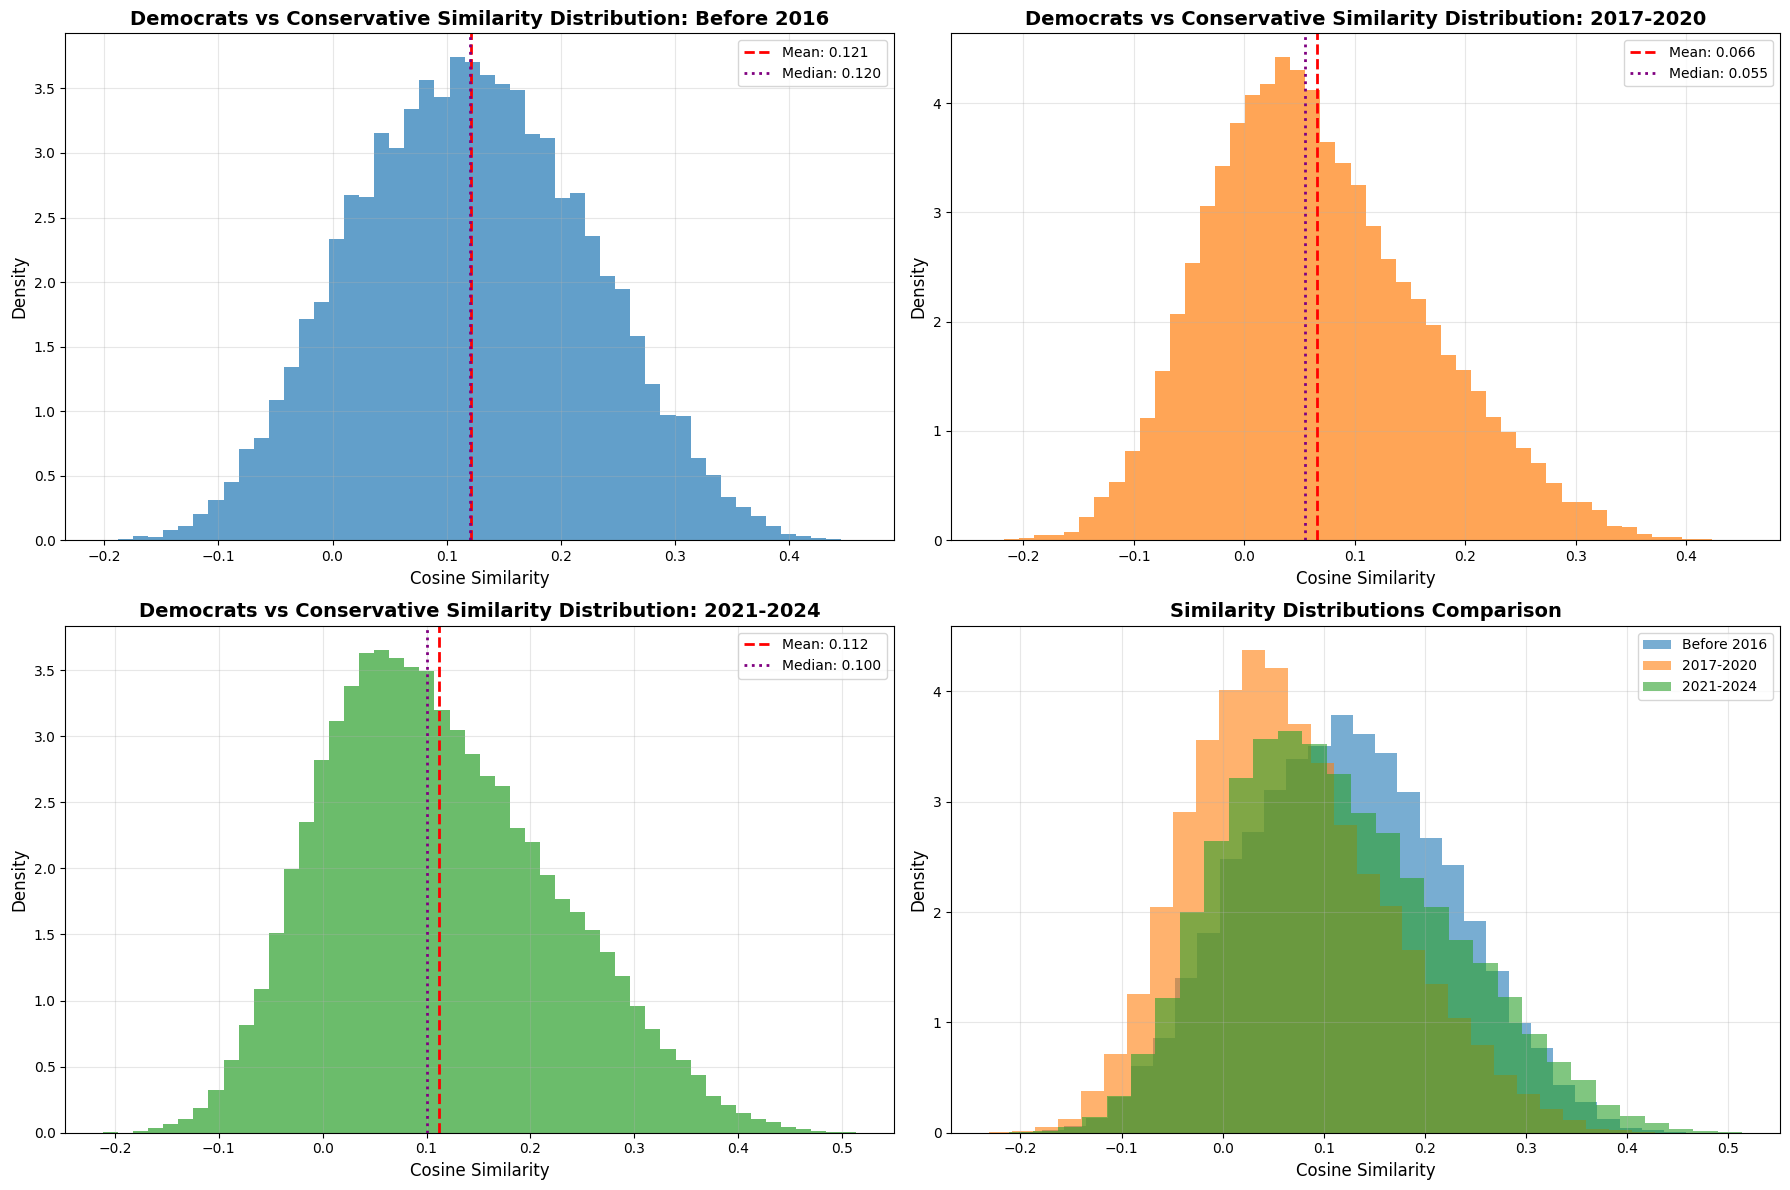

In [3]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Democrats vs Republicans
input_dir = "models/final_full"
democrats_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2021_2024.model")
conservative_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_before_2016.model")
conservative_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_2017_2020.model")
conservative_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_2021_2024.model")


# Define output directory
output_dir = "output/final_full"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016

compare_subreddit_embeddings_by_period(
    democrats_before_2016, 
    conservative_before_2016,
    "democrats", 
    "conservative",
    "before_2016",
    output_file=f"{output_dir}/democrats_conservative_before_2016.csv"
)

# 2017-2020

compare_subreddit_embeddings_by_period(
    democrats_2017_2020, 
    conservative_2017_2020,
    "democrats", 
    "conservative",
    "2017_2020",
    output_file=f"{output_dir}/democrats_conservative_2017_2020.csv"
)

# 2021-2024

compare_subreddit_embeddings_by_period(
    democrats_2021_2024, 
    conservative_2021_2024,
    "democrats", 
    "conservative",
    "2021_2024",
    output_file=f"{output_dir}/democrats_conservative_2021_2024.csv"
)

print("\nAnalysis complete. Generated 6 comparison files.")


def analyze_similarity_distributions(output_dir, df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()



# Run the analysis
# Read the CSV files
democrats_conservative_before_2016 = pd.read_csv(f"{output_dir}/democrats_conservative_before_2016.csv")
democrats_conservative_2017_2020 = pd.read_csv(f"{output_dir}/democrats_conservative_2017_2020.csv")
democrats_conservative_2021_2024 = pd.read_csv(f"{output_dir}/democrats_conservative_2021_2024.csv")

analyze_similarity_distributions(
    output_dir,
    democrats_conservative_before_2016, 
    democrats_conservative_2017_2020, 
    democrats_conservative_2021_2024, 
    "Democrats", 
    "Conservative"
    )